In [1]:
import sys
sys.path.append('../..')
from torchvision.utils import make_grid
from torchvision.models.mobilenet import mobilenet_v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch
import torchvision
from DLBio.pytorch_helpers import get_device
import numpy as np
import matplotlib.pyplot as plt
from ds_ear_siamese import get_siam_dataloader
import transforms_data as td
from siamese_network_train import Training
from ContrastiveLossFunction import ContrastiveLoss
from torch import cuda
from NN_Siamese import SiameseNetwork

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
# Set Up All Configurations here
class Config():
    NN_SIAMESE = False
    training_dir = '../dataset_low_res/'
    testing_dir = '../dataset_testing/'
    # training_dir = "../data/ears/training/"
    # testing_dir = "../data/ears/testing/"
    train_batch_size = 32
    test_batch_size = 1
    vis_batch_size = 8
    num_workers = 3
    
    EPOCHS= 100
    LEARNINGRATE = 0.001
    WEIGHT_DECAY = 1

In [7]:
# define data loader
# dl_train = ds_ear_siamese.get_dataloader(
train_dataloader = get_siam_dataloader(
    data_path=Config.training_dir,
    batch_size=Config.train_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese', # TODO switch to another transform?
    should_invert=False
)

# dl_test = ds_ear_siamese.get_dataloader(
test_dataloader = get_siam_dataloader(
    data_path=Config.testing_dir,
    batch_size=Config.test_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    should_invert=False
)

vis_dataloader = get_siam_dataloader(
    data_path=Config.training_dir,
    batch_size=Config.vis_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese', # TODO switch to another transform?
    should_invert=False
)

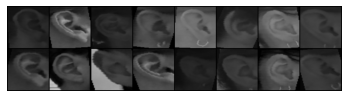

[[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [8]:
# visualize some data....
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(make_grid(concatenated))
print(example_batch[2].numpy())

In [9]:
# Definde Model and load to device
if Config.NN_SIAMESE == False:
    model = mobilenet_v2(pretrained=True)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=5)

    layers = []
    for layer in model.features[0]:
        layers.append(layer)
    model.features[0][0] = nn.ReflectionPad2d(1)
    model.features[0][1] = layers[0]
    model.features[0][2] = layers[1]
    model.features[0].add_module('3', layers[2])
else:
    model = SiameseNetwork()


device = get_device()
print(device)
model.to(device)

contrastive_loss_siamese = ContrastiveLoss(2.0)
optimizer_siamese = torch.optim.Adam(model.parameters(),lr = Config.LEARNINGRATE)



cuda:0


Epoch number 0
 Current loss 1.1858913898468018

Epoch number 0
 Current loss 0.9734091758728027

Epoch number 0
 Current loss 0.7837201952934265

Epoch number 1
 Current loss 0.8060590028762817

Epoch number 1
 Current loss 0.7997716069221497

Epoch number 1
 Current loss 0.7470971345901489

Epoch number 2
 Current loss 0.6610756516456604

Epoch number 2
 Current loss 0.7094564437866211

Epoch number 2
 Current loss 0.5893524289131165

Epoch number 3
 Current loss 0.44223740696907043

Epoch number 3
 Current loss 0.28365349769592285

Epoch number 3
 Current loss 0.3383317291736603

Epoch number 4
 Current loss 0.3451294004917145

Epoch number 4
 Current loss 0.3920627534389496

Epoch number 4
 Current loss 0.45892786979675293

Epoch number 5
 Current loss 0.3426523804664612

Epoch number 5
 Current loss 0.2503284811973572

Epoch number 5
 Current loss 0.3106097877025604

Epoch number 6
 Current loss 0.33623313903808594

Epoch number 6
 Current loss 0.21882613003253937

Epoch number 6


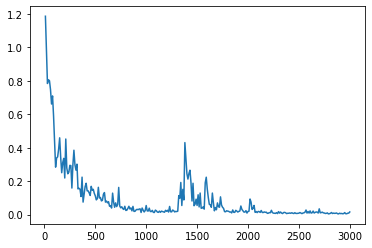

In [10]:
training = Training(model=model, optimizer=optimizer_siamese,train_dataloader=train_dataloader, 
                loss_contrastive=contrastive_loss_siamese, nn_Siamese=Config.NN_SIAMESE)

counter, loss_history = training(Config.EPOCHS)
show_plot(counter, loss_history)

In [11]:
if Config.NN_SIAMESE:
    def generate_output( img_in, img_in2):
        if cuda.is_available():
            return model(Variable(img_in).cuda(), Variable(img_in2).cuda())
        else:
            return model(Variable(img_in), Variable(img_in2))

else:
    def generate_output( img_in):
        if cuda.is_available():
            return model(Variable(img_in).cuda())
        else:
            return model(Variable(img_in))         

In [12]:
iter_batches = iter(test_dataloader)
accuracy_count = 0.0
matches = []
non_matches = []
for i in range(len(iter_batches)):
    # batch size schould be 1 to throw no errors in accessing the next(iter_batches) 
    img0, img1, label = next(iter_batches)
    # appends images to matches, if label is 0 (0 = same)
    ((matches, non_matches)[int(label)]).append( (img0,img1) )

# iterate through both lists and compare the distances of the current entries
for m, n in zip(matches, non_matches):
    # get the models output vectors for the images
    
    if Config.NN_SIAMESE:
        match_out1, match_out2 = generate_output(m[0], m[1])
        non_match_out1, non_match_out2 = generate_output(n[0], n[1])
    else:
        match_out1 = generate_output(m[0])
        match_out2 = generate_output(m[1])                 
        non_match_out1 = generate_output(n[0])
        non_match_out2 = generate_output(n[1])
        
    # positive-positive, positive-negative distance
    euclidean_distance_pp = F.pairwise_distance(match_out1, match_out2)
    euclidean_distance_pn = F.pairwise_distance(non_match_out1, non_match_out2)
    
    # format variables
    fmt_id = '{:<12}'
    fmt_eucl = '{:<.3f}'
    # increase accouracy count if p-p was lower than p-n
    if(euclidean_distance_pp < euclidean_distance_pn): accuracy_count += 1
    # print current stats
    print(fmt_id.format('pos-pos: '), fmt_eucl.format( euclidean_distance_pp.item()) )
    print(fmt_id.format('pos-neg: '),fmt_eucl.format( euclidean_distance_pn.item()) )
    print(fmt_id.format('Acc. count: '), '{:>.0f}'.format(accuracy_count), '\n')

# divide by the minimum length (zip function regulated the steps to the minimum)
print(fmt_id.format('Overall (estimated) accuracy: '), fmt_eucl.format( 100 * accuracy_count / min(len(matches), len(non_matches)) ), ' %')

pos-pos:     0.453
pos-neg:     0.574
Acc. count:  1 

pos-pos:     1.160
pos-neg:     1.278
Acc. count:  2 

pos-pos:     0.928
pos-neg:     1.276
Acc. count:  3 

pos-pos:     0.510
pos-neg:     1.080
Acc. count:  4 

pos-pos:     0.230
pos-neg:     0.329
Acc. count:  5 

pos-pos:     0.124
pos-neg:     0.778
Acc. count:  6 

pos-pos:     0.284
pos-neg:     0.726
Acc. count:  7 

pos-pos:     0.537
pos-neg:     0.331
Acc. count:  7 

pos-pos:     0.206
pos-neg:     1.598
Acc. count:  8 

pos-pos:     0.329
pos-neg:     0.854
Acc. count:  9 

pos-pos:     0.547
pos-neg:     1.035
Acc. count:  10 

pos-pos:     0.465
pos-neg:     0.484
Acc. count:  11 

pos-pos:     0.956
pos-neg:     0.088
Acc. count:  11 

pos-pos:     0.190
pos-neg:     0.323
Acc. count:  12 

pos-pos:     0.776
pos-neg:     0.691
Acc. count:  12 

pos-pos:     0.298
pos-neg:     0.385
Acc. count:  13 

pos-pos:     0.728
pos-neg:     0.489
Acc. count:  13 

pos-pos:     0.657
pos-neg:     1.056
Acc. count:  14 

po

In [ ]:
#model = torch.load('/Users/falcolentzsch/Develope/Bachelorthesis/Bachelorthesis/models/model.pt')

In [10]:
torch.save(model,'/nfshome/vkuegelgen/Documents/Bachelorarbeit/Bachelorthesis/models/model_mobile_ALL_95percent.pt')